In [1]:
import tensorflow as tf
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from hausdorff import hausdorff_distance
import lr_scheduler
from tensorflow.keras.regularizers import l2

import os
import random
import numpy as np
from tqdm import tqdm
from skimage.io import imread,imshow
from skimage.morphology import label
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime

# Dataset

In [2]:
TRAIN_PATH="datasets/BUSIS/train/"
TEST_PATH="datasets/BUSIS/test/"

In [3]:
train_ids=next(os.walk(TRAIN_PATH+'org/'))[2][:]
test_ids=next(os.walk(TEST_PATH+'org/'))[2][:]
print(len(train_ids))

394


In [4]:
input_height = IMG_HEIGHT = 256
input_width = IMG_WIDTH = 256
IMG_CHANNELS = 3

In [5]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + 'org/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TRAIN_PATH + 'gt/' + id_[:-4] + '_GT.bmp'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_train[n][mask > 0.] = 1.

print('Resizing test images and masks')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):   
    path = TEST_PATH + 'org/' + id_
    img = imread(path)[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img #/ 255. #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_path = TEST_PATH + 'gt/' + id_[:-4] + '_GT.bmp'
    mask = imread(mask_path)
    mask = np.expand_dims(mask, axis=-1)
    mask = resize(mask, (input_width, input_height), mode='constant', preserve_range=True)
    mask = mask/255
    Y_test[n][mask > 0.] = 1.

  1%|▊                                                                                 | 4/394 [00:00<00:10, 38.84it/s]

Resizing training images and masks


  2%|█▉                                                                                | 4/168 [00:00<00:04, 37.70it/s]

Resizing test images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [00:04<00:00, 34.54it/s]


In [6]:
print(X_train.shape, Y_test.shape)

(394, 256, 256, 3) (168, 256, 256, 1)


e:\miniconda\envs\tensorflow2-6\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


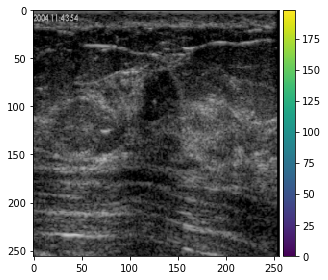

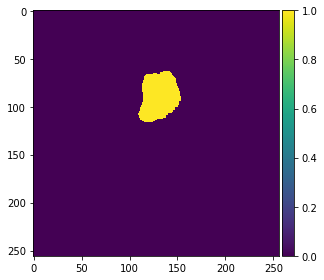

In [7]:
ix=0
imshow(X_train[ix].astype('int'))
plt.show()
imshow(np.squeeze(Y_train[ix].astype('int')))
plt.show()

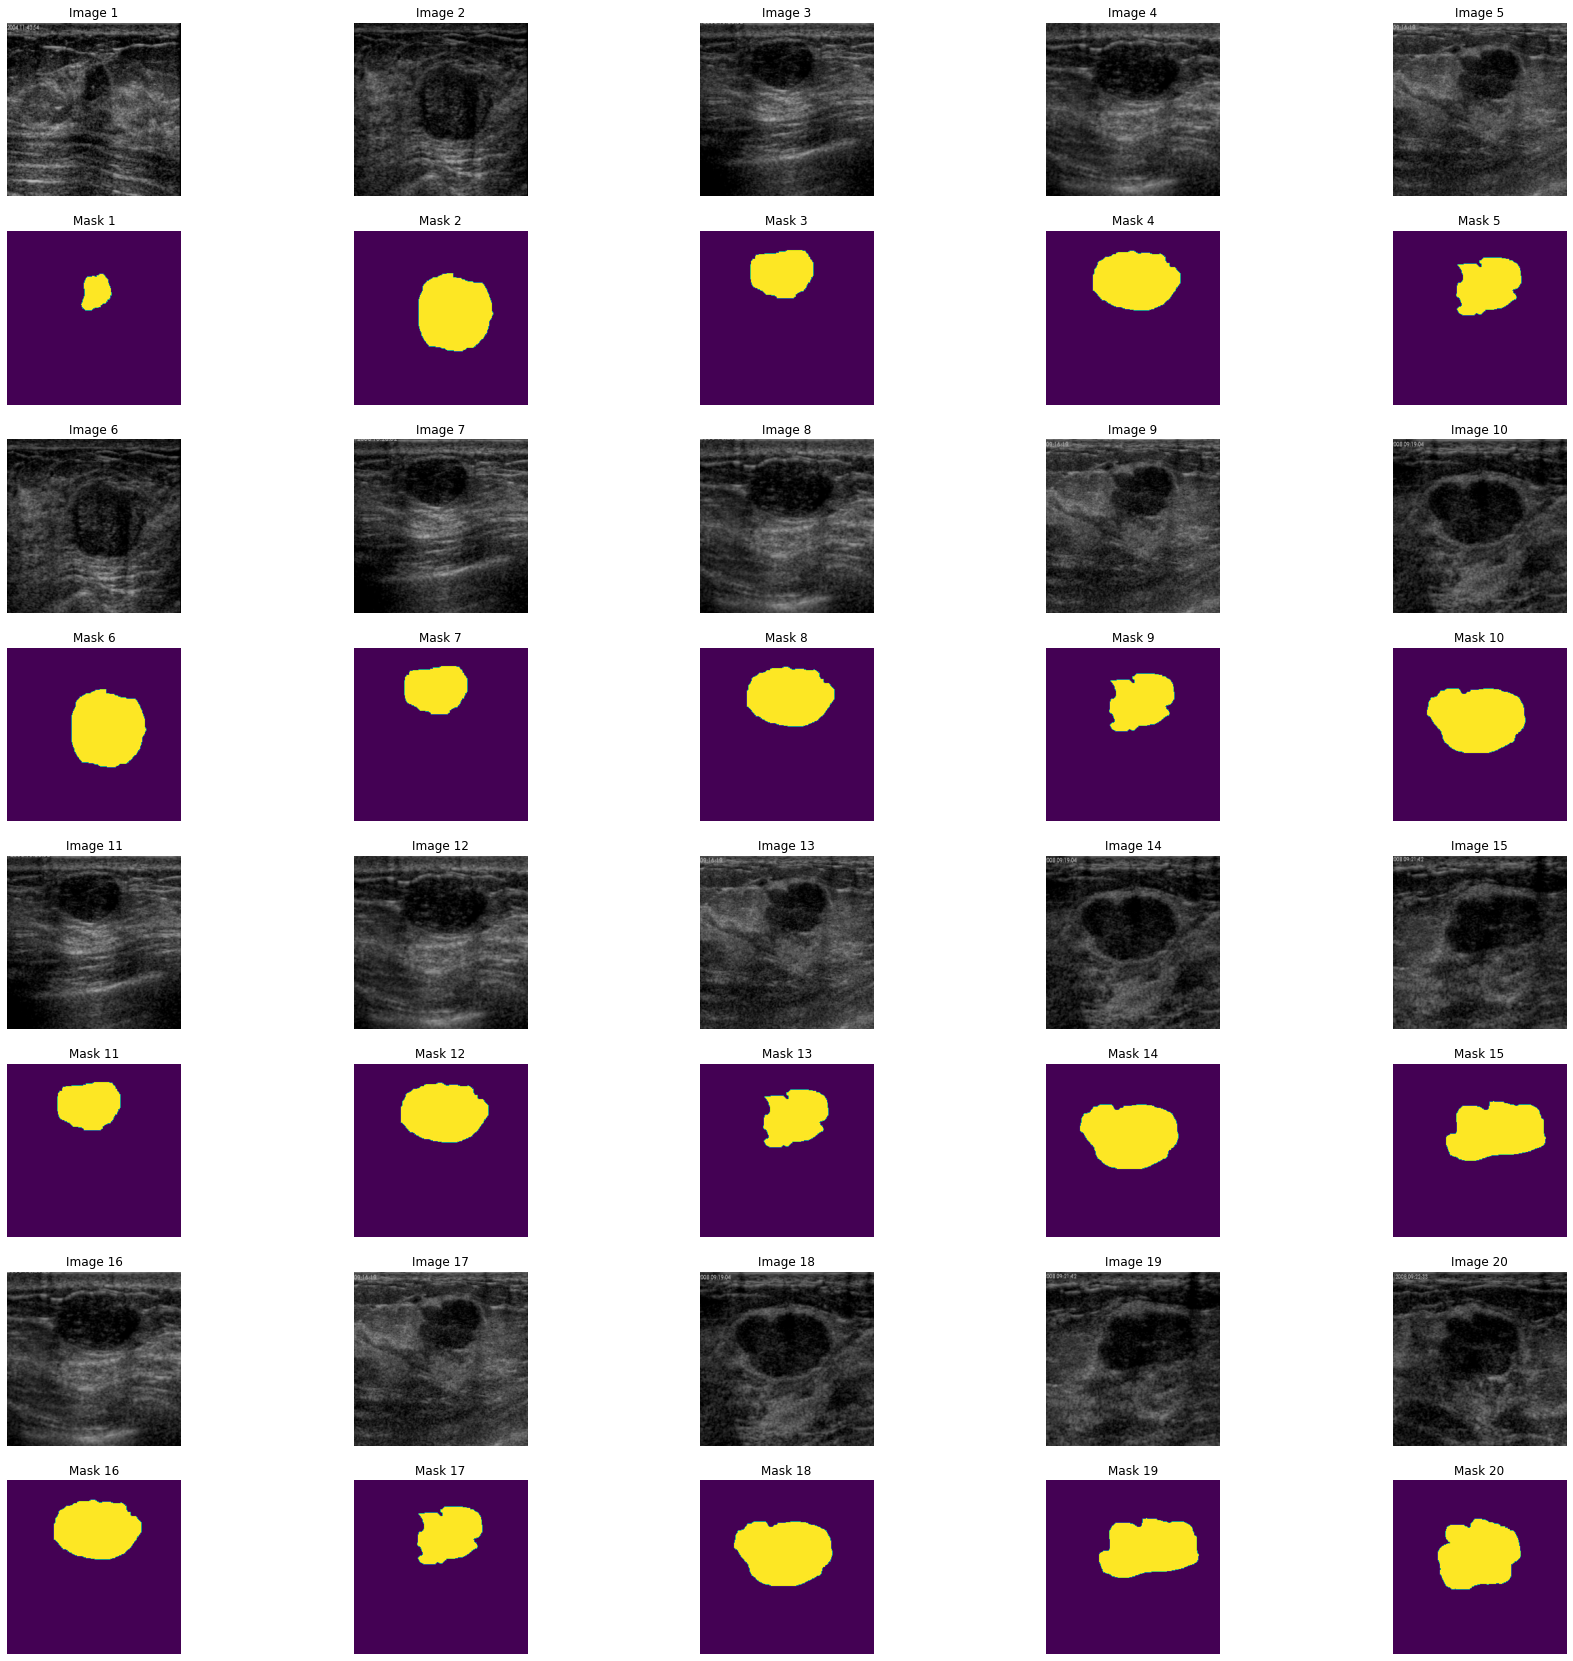

In [8]:
plt.figure(figsize=(30,30))
x, y = 5, 4
count=1
for i in range(y):
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i+j
        plt.imshow(X_train[pos].astype('int'))
        plt.title('Image {}'.format(count))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos].astype('int')))
        plt.title('Mask {}'.format(count))
        plt.axis('off')
        count = count + 1
plt.show()

# Model

In [9]:
def expend_as(tensor, rep):
     return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
    axis = 3
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = SeparableConv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = Dropout(dropout)(conv)

    shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = BatchNormalization(axis=axis)(shortcut)

    res_path = add([shortcut, conv])
    return res_path

def encoder(inputs):
    num_filters = [16, 32, 64, 128]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        a = double_conv_layer(x, 3, f, 0.1, True)
        skip_connections.append(a)
        x = MaxPooling2D(pool_size=(2, 2))(a)
    
    return x, skip_connections

def bottleneck(inputs):
    x = inputs
    f = 256
    
    x3 = double_conv_layer(x, 3, f, 0.1, True)
    
    return x3

def decoder(inputs, skip_connections):
    num_filters = [128, 64, 32, 16]
    skip_connections.reverse()
    x = inputs
    batch_norm = True
    
    for i, f in enumerate(num_filters):
        
        x_up = UpSampling2D(size=(2, 2), data_format="channels_last")(x)
        x_att = concatenate([x_up, skip_connections[i]], axis=-1)
        
        x = double_conv_layer(x_att, 3, f, 0.1, True)
    return x

def output(inputs):
    x = Conv2D(1, kernel_size=(1,1))(inputs)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    return x

# Complete model

In [10]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
#s = inputs
x, skip_1 = encoder(s)
x = bottleneck(x)
x = decoder(x, skip_1)
outputs = output(x)
model = Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 256, 256, 16) 91          rescaling[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          separable_conv2d[0][0]           
______________________________________________________________________________________________

# Metrics

In [12]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    #print('IOU {}'.format(iou))
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    value = 0.
    for batch in range(batch_size):
        value = value + iou_metric(y_true_in[batch], y_pred_in[batch])
    return value/batch_size

def my_iou_metric(label, pred):
    metric_value = tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

def my_iou_metric_loss(label, pred):
    loss = 1-tf.py_function(iou_metric_batch, [label, pred], tf.float32)
    #loss = -tf.map_fn(my_iou_metric_loss(label, pred), tf.range(tf.shape(pred)[0]))
    loss.set_shape((None,))

    return loss

def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def haud_dist(y_true, y_pred):
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)
    
    return hausdorff_distance(y_true,y_pred)

def haud_dist_batch(y_true, y_pred):
    if len(y_true.shape)==2:
        return haud_dist(y_true, y_pred)
    else:
        batch_size = y_true.shape[0]
    hd = 0.
    for batch in range(batch_size):
        hd = hd + haud_dist(y_true[batch], y_pred[batch])
    return hd/batch_size

def my_haud_dist(label, pred):
    metric_value = tf.py_function(haud_dist_batch, [label, pred], tf.float32)
    return metric_value

def evalResult(gt,pred,target_size=(256,256),flag_multi_class = False,num_class = 2):
    gt = np.squeeze(gt)
    pred = np.squeeze(pred)
    
    acc = Accuracy()
    acc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_acc = acc.result().numpy()
    
    pr = Precision()
    pr.update_state(np.squeeze(gt), np.squeeze(pred))
    r_pr = pr.result().numpy()
    
    rc = Recall()
    rc.update_state(np.squeeze(gt), np.squeeze(pred))
    r_rc = rc.result().numpy()
    
    mi = MeanIoU(num_class)
    mi.update_state(np.squeeze(gt), np.squeeze(pred))
    r_mi = mi.result().numpy()
    
    dc = 0.
    for img in range(gt.shape[0]):
        dc = dc + dice_coeff(gt[img], pred[img]).numpy()
    dc = dc / gt.shape[0]
    
    hd = haud_dist_batch(gt,pred)
    
    miou = iou_metric_batch(gt,pred)
    
    mae = MeanAbsoluteError()
    r_mae = mae(np.squeeze(gt), np.squeeze(pred)).numpy()

    print("Accuracy=",r_acc, "Precision=",r_pr, "Recall=",r_rc, "MeanIoU=",r_mi, "DiceCoefficient=",dc, "HD=",hd, "MyIoU=",miou, "MAE=",r_mae)

# Loss

In [13]:
def focal_loss(target_tensor, prediction_tensor, weights=None, alpha=0.25, gamma=2):
    sigmoid_p = tf.nn.sigmoid(prediction_tensor)
    zeros = array_ops.zeros_like(sigmoid_p, dtype=sigmoid_p.dtype)
    
    # For poitive prediction, only need consider front part loss, back part is 0;
    # target_tensor > zeros <=> z=1, so poitive coefficient = z - p.
    pos_p_sub = array_ops.where(target_tensor > zeros, target_tensor - sigmoid_p, zeros)
    
    # For negative prediction, only need consider back part loss, front part is 0;
    # target_tensor > zeros <=> z=1, so negative coefficient = 0.
    neg_p_sub = array_ops.where(target_tensor > zeros, zeros, sigmoid_p)
    per_entry_cross_ent = - alpha * (pos_p_sub ** gamma) * tf.math.log(tf.clip_by_value(sigmoid_p, 1e-8, 1.0))                           - (1 - alpha) * (neg_p_sub ** gamma) * tf.math.log(tf.clip_by_value(1.0 - sigmoid_p, 1e-8, 1.0))
    return tf.reduce_sum(per_entry_cross_ent)

def mean_iou_loss(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.compat.v1.to_int32(y_pred > t)
        score, up_opt = tf.compat.v1.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return -tf.math.log(K.mean(K.stack(prec), axis=0))

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = 0.4*categorical_crossentropy(y_true, y_pred) + 0.6*dice_loss(y_true, y_pred)
    return loss

def bce_dice_loss2(y_true, y_pred):
    fl = focal_loss(y_true, y_pred, gamma=5)
    loss = 0.2*categorical_crossentropy(y_true, y_pred) + 0.3*dice_loss(y_true, y_pred) + 0.5*fl
    return loss

# Callbacks

In [14]:
log_path = "logs/"
keyname = "Unet-without-BT"
cur_date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb_log_dir = log_path + "fit/" + keyname + '_' + cur_date 
tensorboard_callback = TensorBoard(log_dir=tb_log_dir, histogram_freq=0)
model_checkpoint = ModelCheckpoint('model_'+keyname+'.hdf5', monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', verbose=1, patience=20)
csv_logger = CSVLogger(log_path + keyname + '_' + cur_date + '.log', separator=',', append=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

# Training

In [15]:
TRAIN_FLG = 0 # 0 - No Training, 1 - Training
val_split = 0.3
model.compile(
    loss=bce_dice_loss,
    optimizer=Adam(),
    metrics=['accuracy', Precision(), MeanIoU(num_classes=2), Recall(), dice_coeff, MeanAbsoluteError(), my_haud_dist, my_iou_metric]
   )
if TRAIN_FLG:
    print("Training")
    callbacks = [
        model_checkpoint,
        reduce_lr,
        csv_logger,
        tensorboard_callback,
        early_stopping
    ]
    X_train_20 = X_train[:int(X_train.shape[0]*0.2)]
    Y_train_20 = Y_train[:int(Y_train.shape[0]*0.2)]
    results = model.fit(X_train_20, Y_train_20, validation_split=val_split, batch_size=8, epochs=200, callbacks=callbacks)
elif not TRAIN_FLG:
    print("Loading training weights")
    model.load_weights('model_'+keyname+'.hdf5')

Loading training weights


# Evaluate the results

In [16]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*(1-val_split))], verbose=1)
preds_x = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*(1-val_split)):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

gt_train = Y_train[:int(X_train.shape[0]*(1-val_split))].astype(np.float32)
gt_x = Y_train.astype(np.float32)
gt_val = Y_train[int(X_train.shape[0]*(1-val_split)):].astype(np.float32)
gt_test = Y_test.astype(np.float32)

6/6 [==============================] - 1s 152ms/step


In [17]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_x_t = (preds_x > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

In [18]:
evalResult(gt_train, preds_train_t)

Accuracy= 0.9219067 Precision= 0.82322174 Recall= 0.5199679 MeanIoU= 0.6900368 DiceCoefficient= 0.5562504810823907 HD= 7.467450602922497 MyIoU= 0.038322259144135944 MAE= 0.078093365


In [19]:
evalResult(gt_val, preds_val_t)

Accuracy= 0.94513285 Precision= 0.8057853 Recall= 0.61053085 MeanIoU= 0.7368468 DiceCoefficient= 0.6370471595516473 HD= 7.02494345768191 MyIoU= 0.049981824785343264 MAE= 0.05486713


In [20]:
evalResult(gt_x, preds_x_t)

Accuracy= 0.9265637 Precision= 0.8199261 Recall= 0.5347006 MeanIoU= 0.6884812 DiceCoefficient= 0.5724508303186122 HD= 7.378724550958009 MyIoU= 0.0406600908336166 MAE= 0.07343633


In [21]:
evalResult(gt_test, preds_test_t)

Accuracy= 0.92474395 Precision= 0.7898816 Recall= 0.4215118 MeanIoU= 0.65006745 DiceCoefficient= 0.43792161027695764 HD= 7.435280085838808 MyIoU= 0.029993275434024618 MAE= 0.07525607


# Output

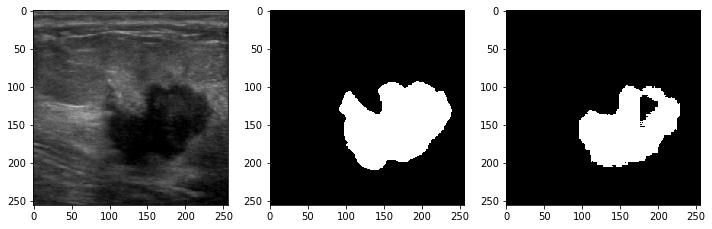

Accuracy= 0.9564514 Precision= 0.982861 Recall= 0.76461875 MeanIoU= 0.85213894 DiceCoefficient= 0.8985592721219291 HD= 6.324555320336759 MyIoU= 0.17343749999999988 MAE= 0.043548584


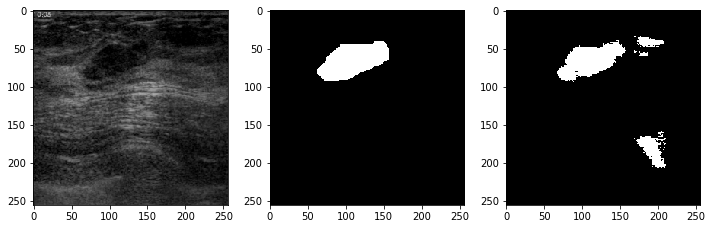

Accuracy= 0.97114563 Precision= 0.6692913 Recall= 0.8173077 MeanIoU= 0.77606434 DiceCoefficient= 0.7610509932783316 HD= 6.708203932499369 MyIoU= 0.08053385416666667 MAE= 0.02885437


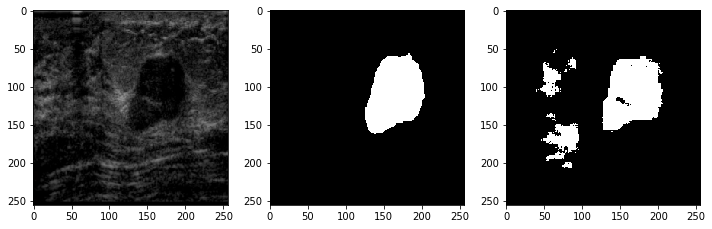

Accuracy= 0.95388794 Precision= 0.6807405 Recall= 0.91418356 MeanIoU= 0.7948127 DiceCoefficient= 0.7386406878795242 HD= 7.0 MyIoU= 0.12188151041666659 MAE= 0.04611206


In [22]:
x=0
xx = [115,10,15]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_train[:int(X_train.shape[0]*(1-val_split))][ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_train_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_train[:int(Y_train.shape[0]*(1-val_split))][ix], preds_train_t[ix])
    x = x+3

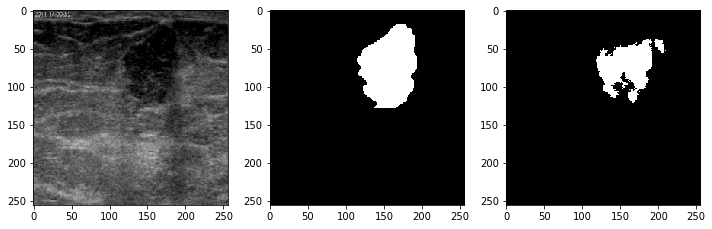

Accuracy= 0.95777893 Precision= 0.9523057 Recall= 0.5829032 MeanIoU= 0.76084185 DiceCoefficient= 0.8099709178204648 HD= 5.291502622129181 MyIoU= 0.07952473958333332 MAE= 0.04222107


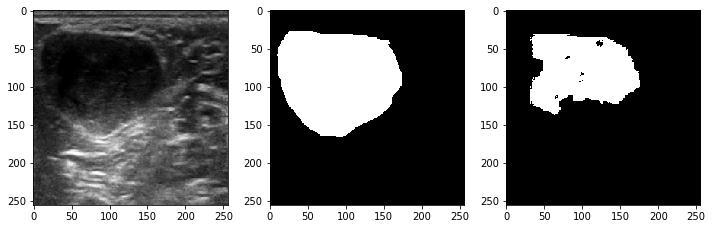

Accuracy= 0.8981323 Precision= 0.9950958 Recall= 0.62330055 MeanIoU= 0.7495368 DiceCoefficient= 0.7813410288545128 HD= 6.557438524302 MyIoU= 0.13870442708333333 MAE= 0.101867676


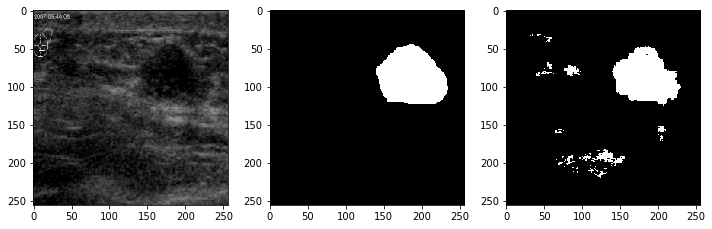

Accuracy= 0.9703827 Precision= 0.81798714 Recall= 0.8326976 MeanIoU= 0.835342 DiceCoefficient= 0.7246006452842266 HD= 7.0710678118654755 MyIoU= 0.14487304687500002 MAE= 0.02961731


In [23]:
x=0
xx = [16,10,15]
for i in range(3):
    plt.figure(figsize=(10,10))
    #ix = random.randint(0, len(preds_train))
    ix = xx[i]
    #print(ix)
    #ix = 58
    plt.subplot(3,3,x+1)
    imshow(X_test[ix].astype('uint8'))
    #plt.title('Image')

    plt.subplot(3,3,x+2)
    imshow(np.squeeze(Y_test[ix]))
    #plt.title('Mask')

    plt.subplot(3,3,x+3)
    imshow(np.squeeze(preds_test_t[ix]))
    #plt.title('Predicted Mask')
    #plt.show()
    
    plt.show()
    evalResult(Y_test[ix], preds_test_t[ix])
    x = x+3